# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


In [324]:
import numpy as np
from numba import njit, prange
from scipy import signal
import matplotlib.pyplot as plt
import time
from tqdm import trange
from IPython.display import Image

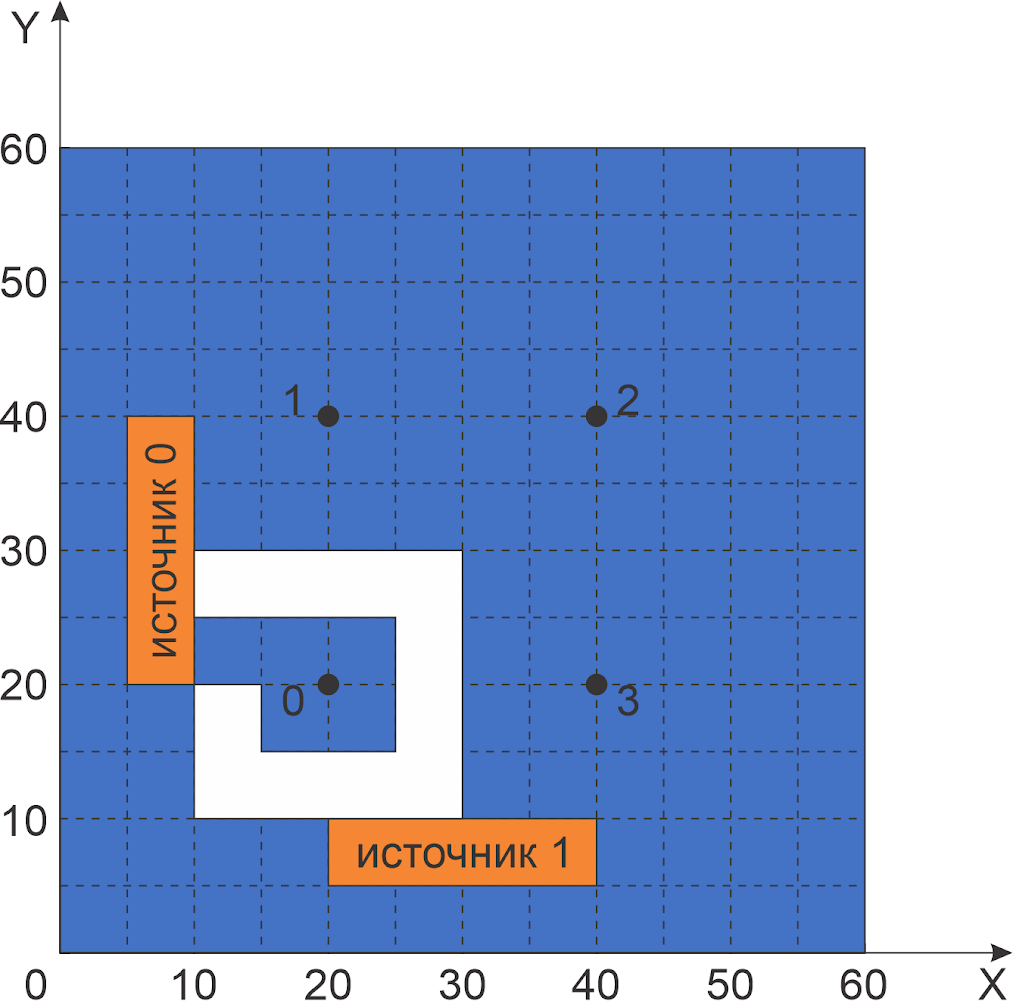

In [325]:

display(Image('C:\\Users\\allll\\Downloads\\var_09 (2).png'))

In [311]:
def create_Dxy(n, D_0, D_1):

    """
    Generate a diffusion matrix indicating diffusion coefficients in different regions of a plate.

    Parameters:
    - n (int): The size of the square matrix representing the plate.
    - D_0 (float): Diffusion coefficient for regions outside specified ranges.
    - D_1 (float): Diffusion coefficient for specified regions.

    Returns:
    - numpy.ndarray: A square matrix (n x n) representing diffusion coefficients across the plate.

    """

    Dxy = np.full((n, n), D_0)

    for i in range(int(10/60 * n), int(30/60 * n)):
        for j in range(int(10/60 * n), int(30/60 * n)):
            Dxy[i, j] = D_1

    for i in range(int(15/60 * n), int(25/60 * n)):
        for j in range(int(15/60 * n), int(25/60 * n)):
            Dxy[i, j] = D_0

    for i in range(int(20/60 * n), int(25/60 * n)):
        for j in range(int(10/60 * n), int(15/60 * n)):
            Dxy[i, j] = D_0

    return Dxy

In [312]:
def abs_therm_ins(T: np.ndarray):
    """
    Абсолютная теплоизоляция
    """
    T[:, -1, :] = T[:, -2, :]
    T[:, :, -1] = T[:, :, -2]
    T[:, 0, :] = 0
    T[:, :, 0] = 0

In [313]:
def power(dt, p, theta):
    #Периодический закон
    q = p * (np.sin(2*np.pi/theta * dt) + 1)
    return q


In [314]:
def heat_source_step(T: np. ndarray, x: int, y: int, h: int, w: int, q, dt: float):
    """
    Apply a heat source to a specified region in a 2D or 3D temperature field.

    Parameters:
    - T (numpy.ndarray): 2D or 3D array representing the temperature field.
    - x (int): Starting x-coordinate of the heat source region.
    - y (int): Starting y-coordinate of the heat source region.
    - h (int): Height of the heat source region.
    - w (int): Width of the heat source region.
    - q (float): Heat source intensity.
    - dt (float): Time step size.

    Returns:
    - None
    """

    T[:, y:y+h, x:x+w] += q * dt


In [315]:
@njit(parallel = True)
def diffuse_step_full(it, N, Dxy, T, dt, dx):

    """
    Perform a single time step of diffusion on a 2D temperature field using an explicit finite difference method.

    Parameters:
    - it (int): Current time step index.
    - N (int): Size of the 2D temperature field along one dimension (assumes a square field).
    - Dxy (numpy.ndarray): Diffusion coefficients matrix.
    - T (numpy.ndarray): 3D array representing the temperature field over time.
    - dt (float): Time step size.
    - dx (float): Spatial step size.

    Returns:
    - None
    """

    prev = it % 2
    cur = (prev + 1) % 2

    for i in prange(1, N - 1):
        for j in range(1, N - 1):
            g = dt * Dxy[i, j] / dx**2
            T[cur, i, j] = T[prev, i, j] + \
                     g * (T[prev, i+1, j] +
                          T[prev, i-1, j] +
                          T[prev, i, j+1] +
                          T[prev, i, j-1] -
                        4 * T[prev, i, j])

In [316]:
def approximate_period(detrended, dt):
    """Approximate period for a data set using fast Fourier transform and peak search"""
    N = detrended.size
    r = np.fft.rfft(detrended - detrended.mean())
    ampl = (np.abs(r) / (N / 2))[:50]
    freq = np.fft.rfftfreq(N, dt)[:50]
    idx, h = signal.find_peaks(ampl)
    return 1 / freq[idx]

In [317]:
def function(N):

    D_0 = 1.0
    D_1 = 1e-2
    L = 60
    C = 0.2
    tmax = 600.0
    p_0 = 100
    th0 = 43
    p_1 = 100
    th1 = 77

    n = N
    dx = L/n
    dt = C * dx**2 / D_0
    it_max = int(tmax / dt)

    h_heat_0 = int(n*(40/60 - 20/60))
    w_heat_0 = int(n*(10/60 - 5/60))
    h_heat_1 = int(n*(10/60 - 5/60))
    w_heat_1 = int(n*(40/60 - 20/60))
    x_heat_0 = int(n*5/60)
    y_heat_0 = int(n*20/60)
    x_heat_1 = int(n*20/60)
    y_heat_1 = int(n*5/60)
    x_sample_0 = int(n*20/60)
    y_sample_0 = int(n*20/60)
    x_sample_1 = int(n*20/60)
    y_sample_1 = int(n*40/60)
    x_sample_2 = int(n*40/60)
    y_sample_2 = int(n*40/60)
    x_sample_3 = int(n*40/60)
    y_sample_3 = int(n*20/60)

    samples = np.array([[x_sample_0, y_sample_0],
                    [x_sample_1, y_sample_1],
                    [x_sample_2, y_sample_2],
                    [x_sample_3, y_sample_3]])


    #Матрица коэффициентов
    Dxy = create_Dxy(n, D_0, D_1)
    np.save('matrix', Dxy)


    #построить изображение матрицы коэффициентов диффузии
    Dxy = np.load('matrix.npy')
    plt.figure(figsize=(7.5, 6))
    plt.title(f'Diffusion coefficients at N = {n}')
    plt.pcolormesh(Dxy, cmap='plasma')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    #расчёты
    T = np.zeros((2, n, n))
    a = [[], [], [], []]
    start = time.time()

    for it in trange(it_max, desc="Прогресс", colour="green"):
        heat_source_step(T, x_heat_0, y_heat_0, h_heat_0, w_heat_0, power(it*dt, p_0, th0), dt)
        heat_source_step(T, x_heat_1, y_heat_1, h_heat_1, w_heat_1,power(it*dt, p_1, th1), dt)
        abs_therm_ins(T)
        diffuse_step_full(it, n, Dxy, T, dt, dx)
        for i in range(4):
            a[i].append(T[it % 2 -1, samples[i, 0], samples[i, 1]])

    end = time.time()
    execution_time = end - start
    print('execution time: ', execution_time)

    #построить цветовую карту поля температур в конечный момент времени
    np.save('matrix_T', T)
    np.save('arr', a)
    T = np.load('matrix_T.npy')

    plt.figure(figsize=(7.5, 6))
    heatmap = plt.pcolormesh(T[0], cmap='inferno')

    plt.scatter(samples[::, 0], samples[::, 1], color='blue')
    for i, (x, y) in enumerate(samples):
        plt.annotate(f'Sample {i}', (x + n / 60, y + n / 60), fontsize=13, color='blue')

    plt.colorbar(heatmap, label='Temperature')
    plt.title(f'Temperature Distribution at N = {n})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


    #Периоды проб
    arr_60 = np.load('arr.npy')

    for j in range(4):
        y = arr_60[j]
        x = np.arange(len(y))
        y_approx = np.poly1d(np.polyfit(x, y, deg=4))(x)
        detrended = y - y_approx
        periods = approximate_period(detrended, dt)
        print('Периоды пробы', j, '-', periods)




    #построить графики температур в местах установки всех четырех проб

    colors = ['red', 'blue', 'orange', 'green']
    styles = {'linestyle': '-', 'markersize': 8}

    plt.figure(figsize=(10, 6))

    for j, (data, color) in enumerate(zip(arr_60, colors)):
        plt.plot(data, label=f'Sample {j}', color=color, **styles)

    plt.grid(ls='--', color='black', alpha=0.5)
    plt.legend()
    plt.ylabel('Temperature')
    plt.xlabel('Time Step (dt)')
    plt.title(f'Temperature Evolution at N = {n}')
    plt.show()



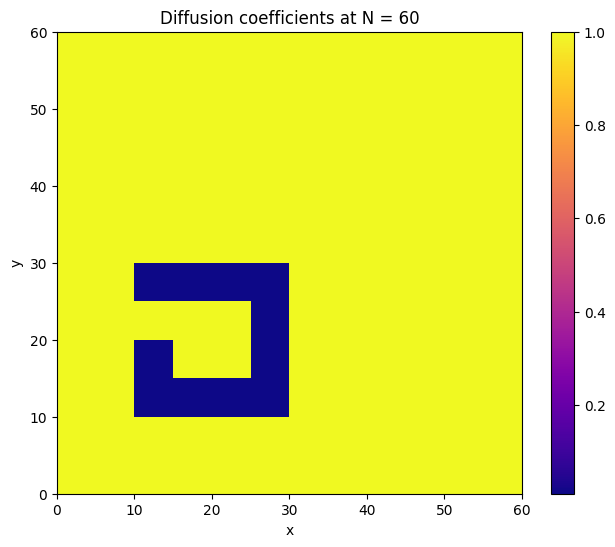

Прогресс: 100%|██████████| 3000/3000 [00:00<00:00, 19350.94it/s]


execution time:  0.1575160026550293


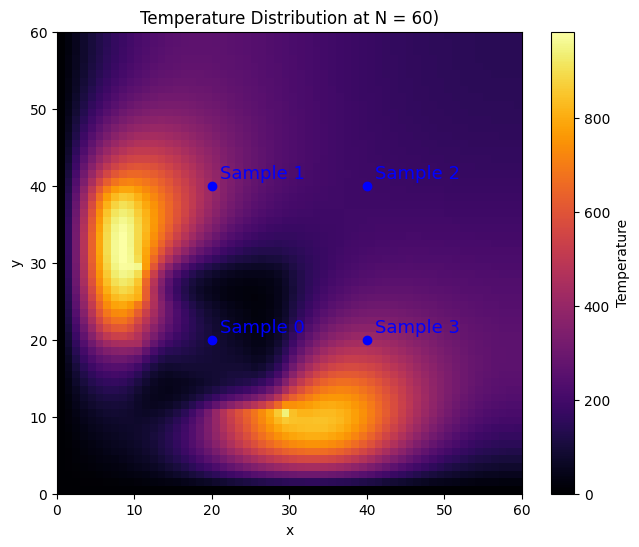

Периоды пробы 0 - [300.          42.85714286]
Периоды пробы 1 - [300.  75.]
Периоды пробы 2 - [300. 150.  75.  40.]
Периоды пробы 3 - [300.         120.          42.85714286]


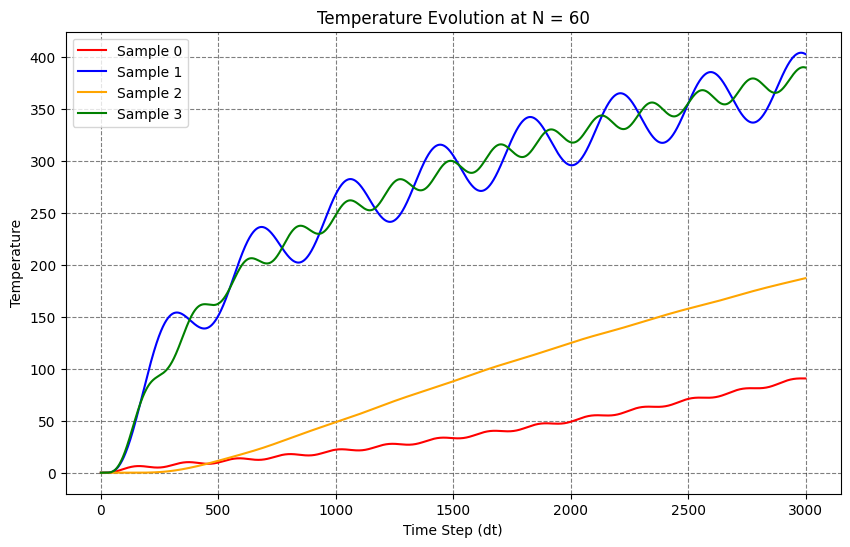

In [319]:
function(60)

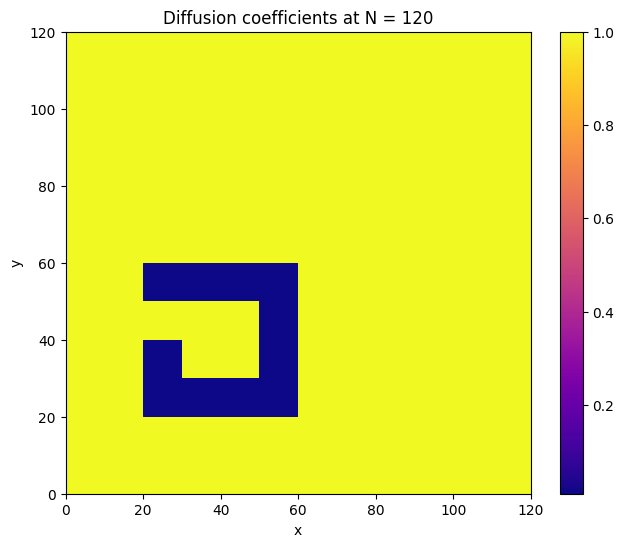

Прогресс: 100%|██████████| 12000/12000 [00:00<00:00, 15399.76it/s]


execution time:  0.7822368144989014


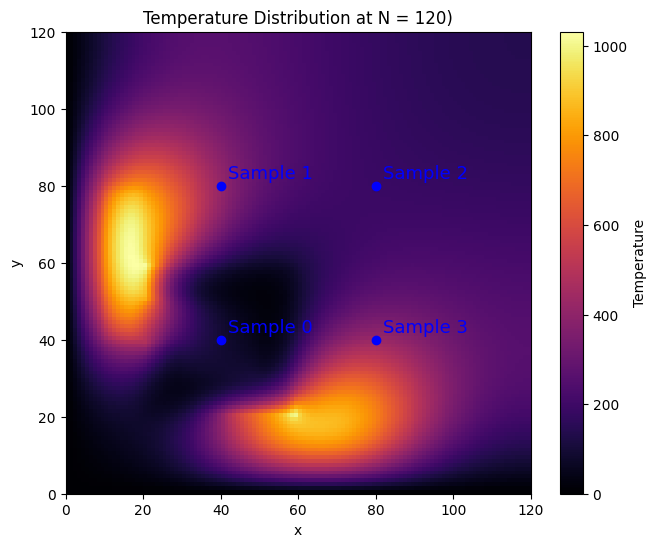

Периоды пробы 0 - [300.          42.85714286]
Периоды пробы 1 - [300.  75.]
Периоды пробы 2 - [300. 150.  75.  40.]
Периоды пробы 3 - [300.         120.          42.85714286]


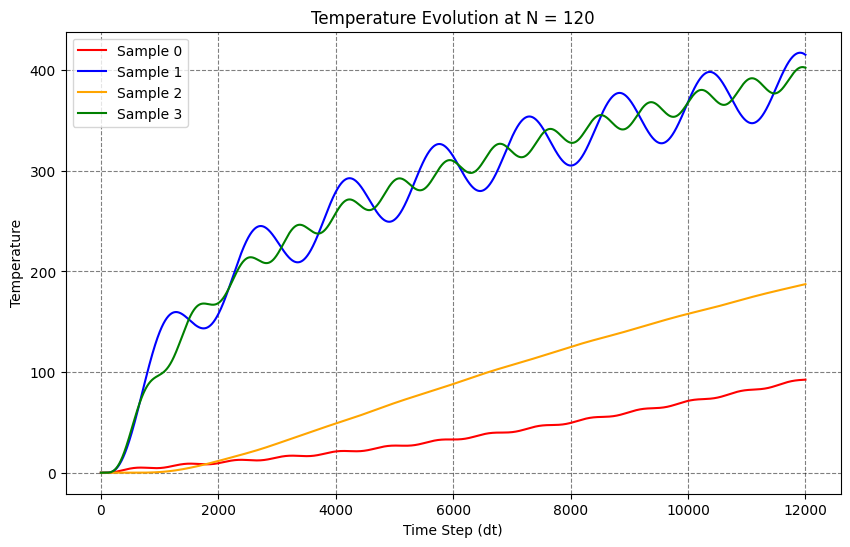

In [320]:
function(120)

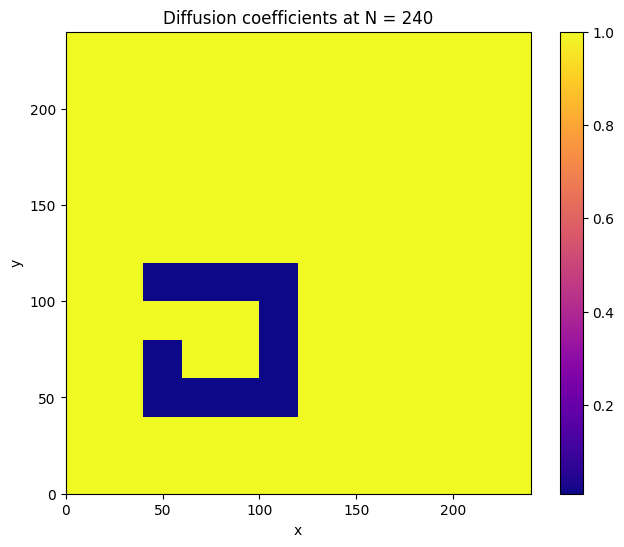

Прогресс: 100%|██████████| 48000/48000 [00:04<00:00, 11755.66it/s]


execution time:  4.086145877838135


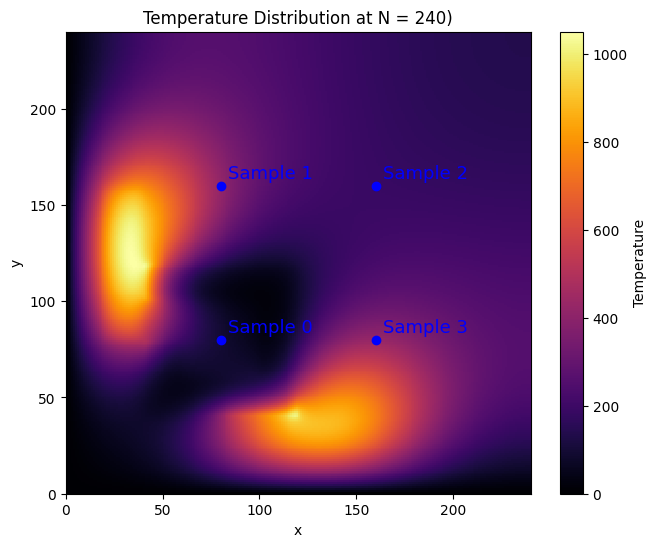

Периоды пробы 0 - [300.          42.85714286]
Периоды пробы 1 - [300.  75.]
Периоды пробы 2 - [300. 150.  75.  40.]
Периоды пробы 3 - [300.         120.          42.85714286]


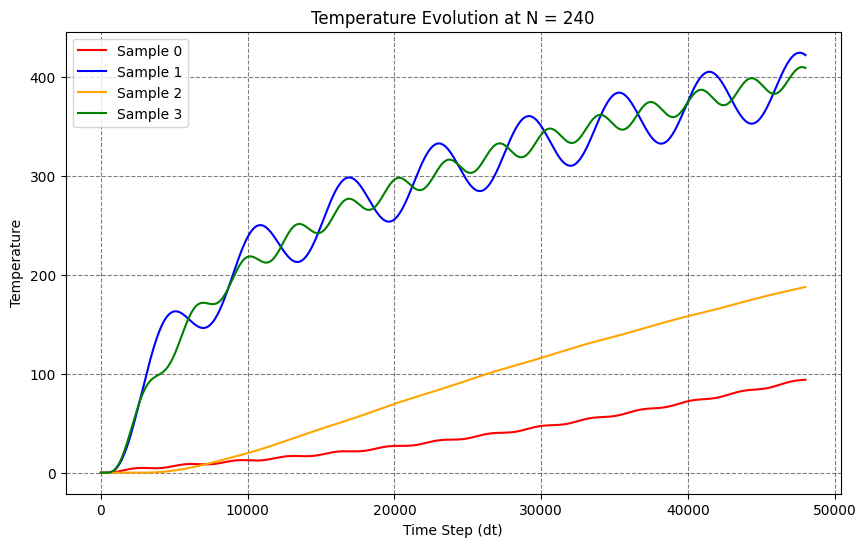

In [321]:
function(240)

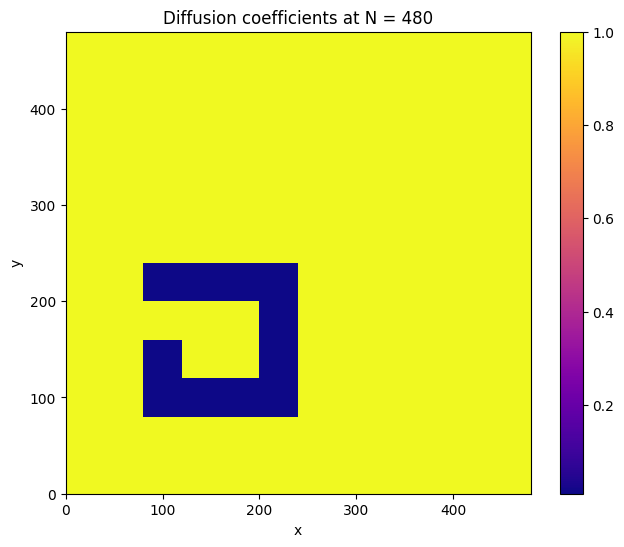

Прогресс: 100%|██████████| 192000/192000 [00:32<00:00, 5947.26it/s]


execution time:  32.28580617904663


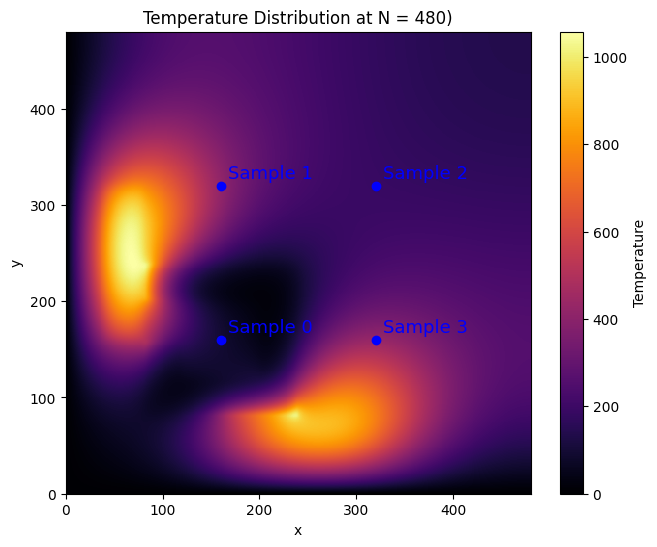

Периоды пробы 0 - [300.          42.85714286]
Периоды пробы 1 - [300.  75.]
Периоды пробы 2 - [300. 150.  75.  40.]
Периоды пробы 3 - [300.         120.          42.85714286]


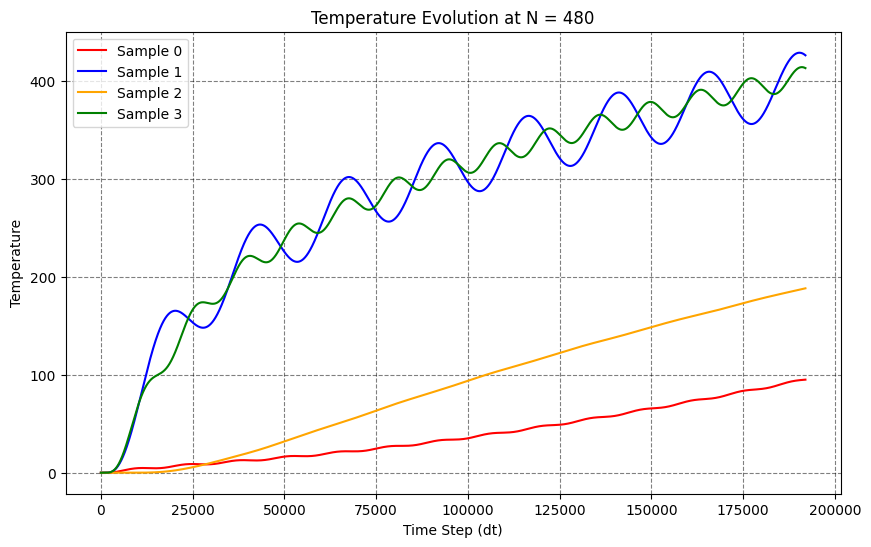

In [322]:
function(480)

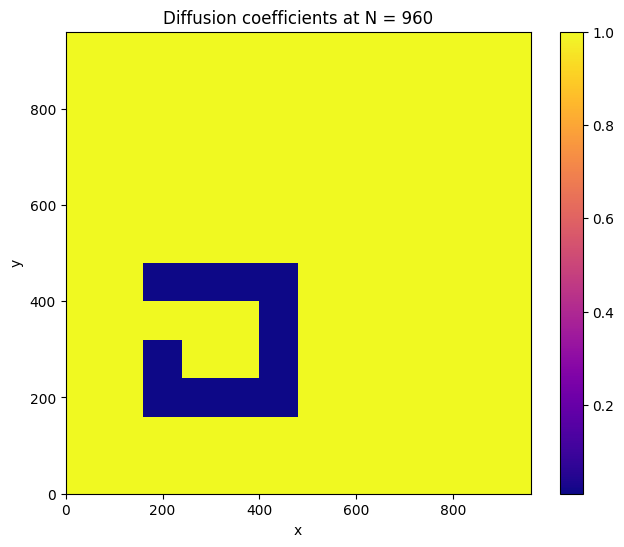

Прогресс: 100%|██████████| 768000/768000 [16:20<00:00, 783.27it/s]


execution time:  980.5088510513306


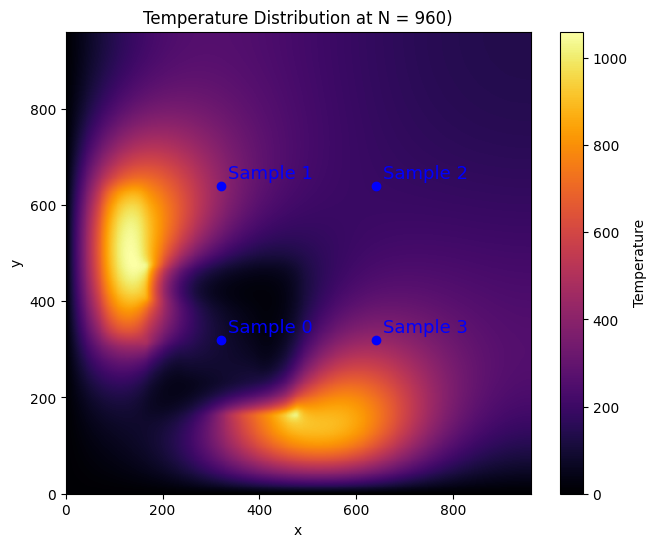

Периоды пробы 0 - [300.          42.85714286]
Периоды пробы 1 - [300.  75.]
Периоды пробы 2 - [300. 150.  75.  40.]
Периоды пробы 3 - [300.         120.          42.85714286]


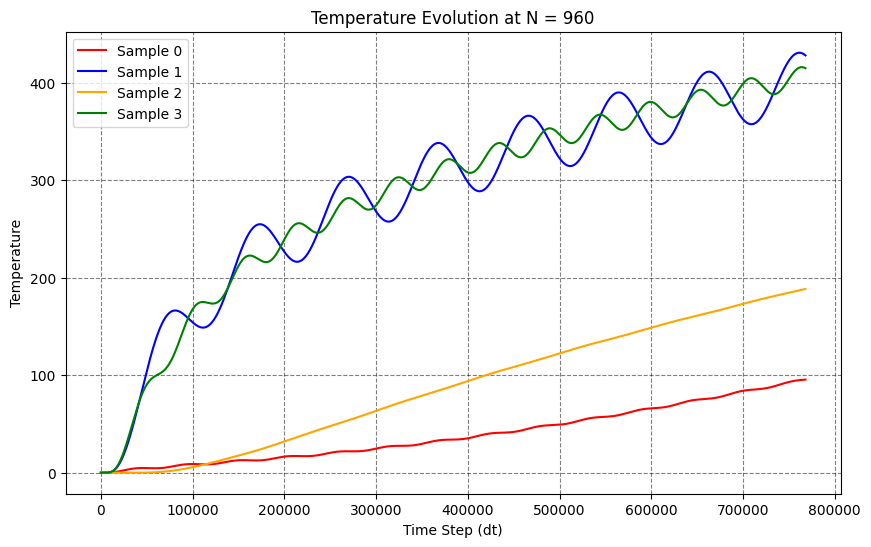

In [323]:
function(960)